## 사진에서 사람영역만 구분(배경지우기)

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

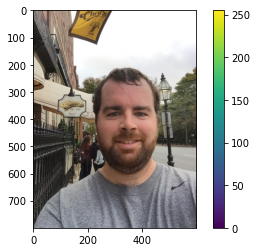

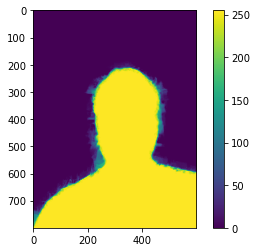

In [41]:
# 데이터를 np array로 training에서 사람 이미지 한장과 영역 이미지 한장을 불러오는 코드를 작성해주세요. (x, y로 변수 대입)
import glob
import imageio
x = imageio.imread('dataset/training/00002.png')
y = imageio.imread('dataset/training/00002_matte.png')
plt.imshow(x)
plt.colorbar()
plt.show()
plt.imshow(y)
plt.colorbar()
plt.show()

In [42]:
# x와 y를 각각 (800, 600, 3) -> (100, 75, 3), (800, 600) -> (100, 75)로 줄이고 plt에서 확인하는 코드를 작성하세요.
from skimage.transform import resize

x1 = resize(x, (100, 75))
y1 = resize(y, (100, 75))


In [43]:
x1.shape, y1.shape

((100, 75, 3), (100, 75))

In [44]:
# pfcn_small.npz에서 train_images, test_images, train_mattes, test_mattes를 np array로 로드하세요.
pfcn_small = np.load('./pfcn_small.npz')

In [45]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

In [46]:
train_images.dtype

dtype('float64')

## 데이터 전처리

In [47]:
print(train_images.max(), train_images.min())
print(test_images.max(), test_images.min())

1.0 0.0
1.0 0.0


In [48]:
# (배치, 100, 75,3)의 흑백 shape을 (배치, 100, 75, 1)의 흑백 shape의 영역으로 축소하는 코드를 추가하세요.
from skimage import color
from skimage.color import rgb2gray

train_mattes = np.array( [color.rgb2gray(img).reshape((100,75,1)) for img in train_mattes])
test_mattes = np.array( [color.rgb2gray(img).reshape((100,75,1)) for img in test_mattes])
train_mattes.shape, test_mattes.shape

((1700, 100, 75, 1), (300, 100, 75, 1))

In [49]:
# (배치, 100, 75, 3)인 train_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성하세요.
train_images[:5].shape

(5, 100, 75, 3)

In [50]:
# 해당 기능을 이용해서 (100, 375, 3)을 작성하는 코드를 작성해보세요.
train_images[:5].transpose(1,0,2,3).reshape((100, -1, 3)).shape

(100, 375, 3)

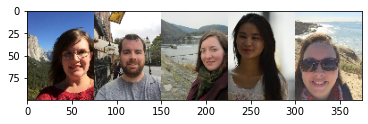

In [51]:
plt.imshow(train_images[:5].transpose(1,0,2,3).reshape((100, -1, 3)))
plt.show()

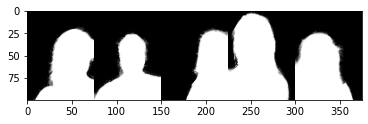

In [52]:
plt.imshow(train_mattes[:5].transpose(1,0,2,3).reshape((100, -1)), cmap='gray')
plt.show()

## 모델 구현

In [87]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

def ae_like():
    inputs = Input((100, 75, 3))
    x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    latent = Dense(10)(x)
    
    x = Dense((13*10*128))(latent)
    x = Reshape((13, 10 ,128))(x)
    
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)
    
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)
    
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)
    
    x = Conv2D(1, (1,1), (1,1), activation='relu', padding='valid')(x)
    
    model = Model(inputs, x)
    
    return model

In [88]:
model = ae_like()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten_15 (Flatten)         (None, 16640)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                166410    
_________________________________________________________________
dense_23 (Dense)             (None, 16640)             1830

In [89]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [90]:
hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 27s 320ms/step - loss: 0.2207 - accuracy: 0.6637 - val_loss: 0.1250 - val_accuracy: 0.7631
Epoch 2/25
54/54 [==============================] - 17s 312ms/step - loss: 0.1226 - accuracy: 0.7697 - val_loss: 0.1177 - val_accuracy: 0.7727
Epoch 3/25
54/54 [==============================] - 17s 315ms/step - loss: 0.1169 - accuracy: 0.7770 - val_loss: 0.1110 - val_accuracy: 0.7813
Epoch 4/25
54/54 [==============================] - 16s 303ms/step - loss: 0.1077 - accuracy: 0.7894 - val_loss: 0.0972 - val_accuracy: 0.8018
Epoch 5/25
54/54 [==============================] - 16s 300ms/step - loss: 0.0887 - accuracy: 0.8173 - val_loss: 0.0873 - val_accuracy: 0.8155
Epoch 6/25
54/54 [==============================] - 16s 294ms/step - loss: 0.0791 - accuracy: 0.8277 - val_loss: 0.0771 - val_accuracy: 0.8276
Epoch 7/25
54/54 [==============================] - 16s 296ms/step - loss: 0.0682 - accuracy: 0.8427 - val_loss: 0.0728 - val_accuracy: 0.8325

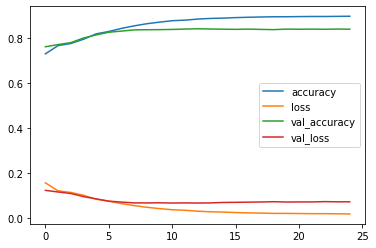

In [92]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend(loc = "center right")
plt.show()

## 결과 확인

In [93]:
res = model.predict(test_images[0:1])

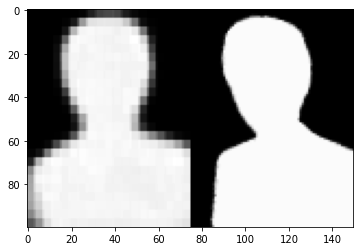

In [98]:
# res, test_mattes[1]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([res[0], test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)),cmap = "gray")

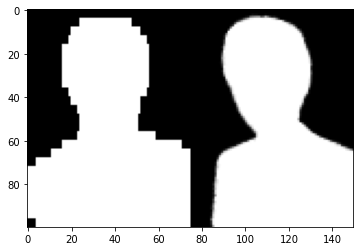

In [99]:
# res를 0.5기준으로 0,1의 값으로 이원화 시킨 뒤 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([(res[0]>0.5).astype(np.float64), test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)),cmap = "gray")

In [100]:
# 5장의 이미지를 모델에 넣고 결과를 같은 방식으로 비교하는 코드를 작성하세요
five = model.predict(test_images[:5] > 0.5).astype(np.float64)

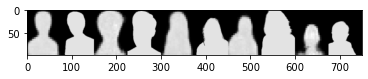

In [102]:
plt.imshow(np.concatenate([five, test_mattes[:5]], axis = 2).transpose([1, 0, 2, 3]).reshape((100, -1)),cmap = "gray")

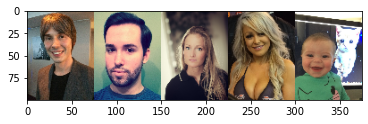

In [103]:
plt.imshow(test_images[:5].transpose((1,0,2,3)).reshape((100,-1,3)))
plt.show()

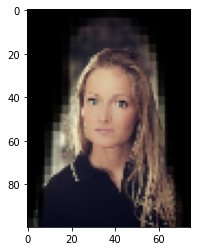

In [110]:
# 예측 이미지와 원본이미지를 곱하여 배경을 지워보세요
plt.imshow(five[2].reshape((100,75,1))*test_images[2])

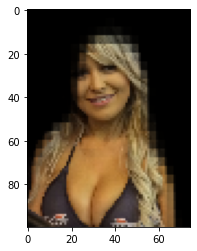

In [111]:
plt.imshow(five[3].reshape((100,75,1))*test_images[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


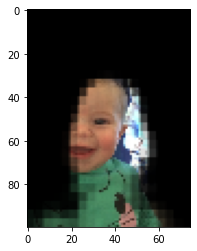

In [113]:
plt.imshow(five[4].reshape((100,75,1))*test_images[4])